In [1]:
import numpy as np

import tensorflow as tf
import sonnet as snt
import matplotlib.pyplot as plt

import datasets.dataset_bouncingMnistOriginal as dataset

In [2]:
"""Hyperparameters"""
batch_size = 16
image_size = (64,64,1)
num_input_frames = 10
num_output_frames = 10
dynamic_filter_size = (9,9)
num_frames = num_input_frames + num_output_frames
num_epochs = 100
batches_per_epoch = 200
learning_rate = 1e-4

In [3]:
"""Setting up the data"""
dh = dataset.DataHandler(num_frames=num_frames, batch_size=batch_size, image_size=image_size[0])
def get_batch():
    frames = dh.GetBatch() # (batch, c, h, w, frames)
    frames = np.transpose(frames, [0,2,3,1,4]) # (batch, h, w, c, frames)
    return frames

# # Uncomment to show a data sample
# frames = get_batch()
# print(np.min(frames), np.max(frames))
# for i in range(frames.shape[-1]):
#     plt.imshow(frames[0,:,:,0,i], cmap="gray")
#     plt.show()

In [4]:
"""Defining the model (using a Sonnet module)"""
class Model(snt.AbstractModule):
    def __init__(self, filter_size=(9,9), name="model"):
        super(Model, self).__init__(name=name)
        self._filter_size = filter_size
        self._refinement_network = False
        self._dynamic_bias = False
    
    def _build(self, input_frames):
        hidden_state = tf.zeros((batch_size, image_size[0]/2, image_size[1]/2, 128))
        input_frames = tf.unstack(input_frames, axis=-1)
        output_frames = []
        for i in range(num_input_frames + num_output_frames - 1):
            if i < num_input_frames:
                input_frame = input_frames[i]
            else:
                input_frame = prediction
            prediction, hidden_state = self._predict(input_frame, hidden_state)
            
            if i >= num_input_frames - 1:
                output_frames.append(prediction)
        return tf.stack(output_frames, -1)
            
    def _predict(self, input_frame, hidden_state):
        with tf.variable_scope("forward_net", reuse=tf.AUTO_REUSE):
            ###############################
            #  filter-generating network  #
            ###############################
            ## encoder
            output = tf.layers.conv2d(input_frame, filters=32, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            output = tf.layers.conv2d(output, filters=32, kernel_size=[3,3], strides=[2,2], padding="same", activation=tf.nn.leaky_relu)
            output = tf.layers.conv2d(output, filters=64, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            output = tf.layers.conv2d(output, filters=64, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)

            ## mid
            output = tf.layers.conv2d(output, filters=128, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            
            hidden = tf.layers.conv2d(hidden_state, filters=128, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            hidden = tf.layers.conv2d(hidden, filters=128, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            output = output + hidden
            hidden_state = output

            ## decoder
            output = tf.layers.conv2d(output, filters=64, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            output = tf.layers.conv2d(output, filters=64, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            output = tf.image.resize_nearest_neighbor(output, size=(2*output.get_shape()[1].value, 2*output.get_shape()[2].value), align_corners=False)
            output = tf.layers.conv2d(output, filters=64, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)
            output = tf.layers.conv2d(output, filters=64, kernel_size=[3,3], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)

            output = tf.layers.conv2d(output, filters=128, kernel_size=[1,1], strides=[1,1], padding="same", activation=tf.nn.leaky_relu)

            dynamic_filters = tf.layers.conv2d(output, filters=self._filter_size[0]*self._filter_size[1], kernel_size=[1,1], padding="same")
            dynamic_filters = tf.nn.softmax(dynamic_filters, axis=-1)

            if self._dynamic_bias:
                dynamic_bias = tf.layers.conv2d(output, filters=1, kernel_size=[1,1], padding="same")
            else:
                dynamic_bias = 0

            #########################
            #  transformer network  #
            #########################
            input_frame_transformed = tf.extract_image_patches(
                input_frame + dynamic_bias, [1, self._filter_size[0], self._filter_size[1], 1],
                strides=[1,1,1,1], rates=[1,1,1,1], padding="SAME")

            output_dynconv = tf.reduce_sum(dynamic_filters * input_frame_transformed, -1, keepdims=True)

            ########################
            #  refinement network  #
            ########################
            if self._refinement_network:
                raise NotImplementedError
            else:
                output = output_dynconv

            prediction = output
        return prediction, hidden_state

In [5]:
def get_number_of_variables():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    return total_parameters

In [6]:
tf.reset_default_graph()

# Set up placeholders
input_frames = tf.placeholder(tf.float32, shape=(batch_size,) + image_size + (num_input_frames,))
output_frames = tf.placeholder(tf.float32, shape=(batch_size,) + image_size + (num_output_frames,))

# Initialize the model
model = Model(filter_size=dynamic_filter_size)
predictions = model(input_frames)

# Clip the predictions to lie in [0+eps,1-eps], so they can be fed to the bce loss function.
predictions = tf.clip_by_value(predictions, np.finfo(np.float32).eps, 1-np.finfo(np.float32).eps)

# Binary cross-entropy loss function
bce = -output_frames*tf.log(predictions) - (1-output_frames)*tf.log(1-predictions)
frame_loss = tf.reduce_mean(bce, [1,2,3])
batch_loss = tf.reduce_mean(frame_loss, -1)
loss = tf.reduce_mean(batch_loss, 0)

# Setting up the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

# Main training loop
print("Number of trainable variables: {}".format(get_number_of_variables()))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(num_epochs*batches_per_epoch):
        frames = get_batch()
        _, loss_, predictions_, output_frames_ = sess.run([train_step, loss, predictions, output_frames], 
                            feed_dict={input_frames: frames[:,:,:,:,:num_input_frames],
                                       output_frames: frames[:,:,:,:,num_input_frames:]})
        if step % batches_per_epoch == 0:
            print("step {}: {}".format(step, loss_))

Number of trainable variables: 637361
step 0: 0.188147425652
step 200: 0.172864109278
step 400: 0.148750826716
step 600: 0.14619037509
step 800: 0.14079734683
step 1000: 0.132678329945
step 1200: 0.13169375062
step 1400: 0.123050458729
step 1600: 0.138654798269
step 1800: 0.108268171549
step 2000: 0.108702003956
step 2200: 0.119791224599
step 2400: 0.100986845791
step 2600: 0.124250985682
step 2800: 0.113862849772
step 3000: 0.108988255262
step 3200: 0.111163198948
step 3400: 0.115988686681
step 3600: 0.111781135201
step 3800: 0.10149051249
step 4000: 0.10397644341
step 4200: 0.102068722248
step 4400: 0.100963830948
step 4600: 0.0994943231344
step 4800: 0.0927717983723
step 5000: 0.105177082121
step 5200: 0.0996600389481
step 5400: 0.0961814671755
step 5600: 0.102031096816
step 5800: 0.0958395004272
step 6000: 0.0930742844939
step 6200: 0.0952256992459
step 6400: 0.0907455682755
step 6600: 0.0954805538058
step 6800: 0.0977541208267
step 7000: 0.0859362185001
step 7200: 0.100127443671
s

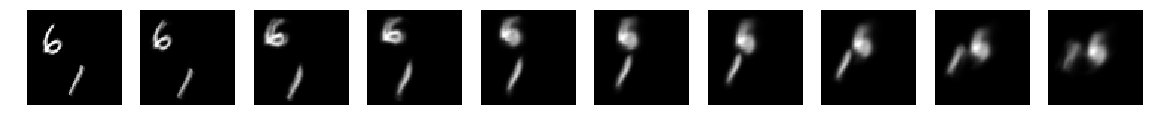

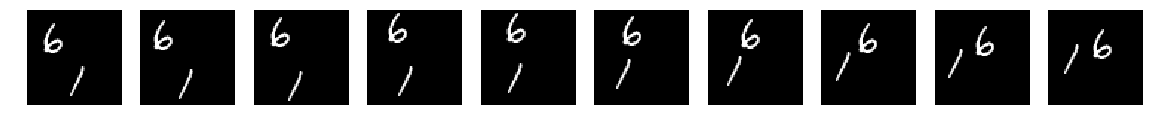

In [7]:
"""Visualize a result."""
plt.rcParams['figure.figsize'] = (20.0, 10.0)

batch_num = 0

for i in range(num_output_frames):
    plt.subplot(1,num_output_frames,i+1)
    plt.imshow(predictions_[batch_num,:,:,0,i], cmap="gray")
    plt.axis("off")
plt.show()

for i in range(num_output_frames):
    plt.subplot(1,num_output_frames,i+1)
    plt.imshow(output_frames_[batch_num,:,:,0,i], cmap="gray")
    plt.axis("off")
plt.show()